# Heart Disease ML Portfolio Project
This notebook implements K-means clustering, PCA, and supervised learning on the Heart Disease UCI dataset (Cleveland subset).

## Data Preprocessing
Cleaning, encoding, scaling, and feature engineering for the Cleveland dataset.

In [63]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import Scikit modules
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Load dataset
df = pd.read_csv('../data/heart_disease_uci.csv')

# Filter to Cleveland data
df_cleveland = df[df['dataset'] == 'Cleveland'].copy()
print("Cleveland Shape:", df_cleveland.shape)

Cleveland Shape: (304, 16)


In [64]:
# Check missing values
print("Missing Values:\n", df_cleveland.isnull().sum())

# Impute numerical columns with median
df_cleveland['trestbps'] = df_cleveland['trestbps'].fillna(df_cleveland['trestbps'].median())
df_cleveland['chol'] = df_cleveland['chol'].fillna(df_cleveland['chol'].median())
df_cleveland['thalch'] = df_cleveland['thalch'].fillna(df_cleveland['thalch'].median())
df_cleveland['oldpeak'] = df_cleveland['oldpeak'].fillna(df_cleveland['oldpeak'].median())
df_cleveland['ca'] = df_cleveland['ca'].fillna(df_cleveland['ca'].median())

# Convert boolean-like columns to string to avoid warning
df_cleveland['fbs'] = df_cleveland['fbs'].astype(str)
df_cleveland['exang'] = df_cleveland['exang'].astype(str)

# Impute categorical columns with mode
df_cleveland['fbs'] = df_cleveland['fbs'].fillna(df_cleveland['fbs'].mode()[0])
df_cleveland['restecg'] = df_cleveland['restecg'].fillna(df_cleveland['restecg'].mode()[0])
df_cleveland['exang'] = df_cleveland['exang'].fillna(df_cleveland['exang'].mode()[0])
df_cleveland['slope'] = df_cleveland['slope'].fillna(df_cleveland['slope'].mode()[0])
df_cleveland['thal'] = df_cleveland['thal'].fillna(df_cleveland['thal'].mode()[0])

# Verify no missing values
print("\nMissing Values After Imputation:\n", df_cleveland.isnull().sum())

Missing Values:
 id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       1
ca          5
thal        3
num         0
dtype: int64

Missing Values After Imputation:
 id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64


### Encoding Categorical Variables
Converting categorical columns to numerical format for ML models.

In [65]:
# Label encode binary/categorical columns
le = LabelEncoder()
df_cleveland['sex'] = le.fit_transform(df_cleveland['sex'])
df_cleveland['fbs'] = le.fit_transform(df_cleveland['fbs'])
df_cleveland['exang'] = le.fit_transform(df_cleveland['exang'])

# One-hot encode multi-class categorical columns
df_cleveland = pd.get_dummies(df_cleveland, columns=['cp', 'restecg', 'slope', 'thal'], drop_first=True)

# Binarize target (num: 0 vs 1-4)
df_cleveland['target'] = df_cleveland['num'].apply(lambda x: 0 if x == 0 else 1)
print("\nTarget Distribution:\n", df_cleveland['target'].value_counts())


Target Distribution:
 target
0    165
1    139
Name: count, dtype: int64


### Scaling Numerical Features
Standardizing numerical features for K-means and PCA.

In [66]:
# Select numerical features
numerical_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
scaler = StandardScaler()
df_cleveland[numerical_cols] = scaler.fit_transform(df_cleveland[numerical_cols])

print("\nScaled Features Sample:\n", df_cleveland[numerical_cols].head())


Scaled Features Sample:
         age  trestbps      chol    thalch   oldpeak        ca
0  0.946671  0.759079 -0.255962  0.012072  1.090644 -0.709371
1  1.384538  1.614169  0.762828 -1.822829  0.400262  2.509268
2  1.384538 -0.666070 -0.332852 -0.905379  1.349537  1.436388
3 -1.899464 -0.096010  0.070820  1.628532  2.126216 -0.709371
4 -1.461597 -0.096010 -0.813413  0.973210  0.313965 -0.709371


### Feature Engineering
Creating new features to enhance model performance.

In [67]:
# Create interaction term: age * chol
df_cleveland['age_chol'] = df_cleveland['age'] * df_cleveland['chol']

# Create binary feature: high_risk_bp (trestbps > 140, scaled)
df_cleveland['high_risk_bp'] = (df_cleveland['trestbps'] > scaler.mean_[numerical_cols.index('trestbps')]).astype(int)

print("\nNew Features Sample:\n", df_cleveland[['age_chol', 'high_risk_bp']].head())


New Features Sample:
    age_chol  high_risk_bp
0 -0.242312             0
1  1.056164             0
2 -0.460846             0
3 -0.134519             0
4  1.188882             0


### Data Cleanup
Dropping non-relevant columns to streamline the DataFrame.

In [68]:
# Drop non-relevant columns
df_cleveland = df_cleveland.drop(columns=['id', 'dataset', 'num'], errors='ignore')
print("Updated Columns:\n", df_cleveland.columns.tolist())
print("\nColumn Data Types:\n", df_cleveland.dtypes)

Updated Columns:
 ['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalch', 'exang', 'oldpeak', 'ca', 'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'restecg_normal', 'restecg_st-t abnormality', 'slope_flat', 'slope_upsloping', 'thal_normal', 'thal_reversable defect', 'target', 'age_chol', 'high_risk_bp']

Column Data Types:
 age                         float64
sex                           int64
trestbps                    float64
chol                        float64
fbs                           int64
thalch                      float64
exang                         int64
oldpeak                     float64
ca                          float64
cp_atypical angina             bool
cp_non-anginal                 bool
cp_typical angina              bool
restecg_normal                 bool
restecg_st-t abnormality       bool
slope_flat                     bool
slope_upsloping                bool
thal_normal                    bool
thal_reversable defect         bool
target          

### Initial Visualizations
Exploring data relationships and distributions.

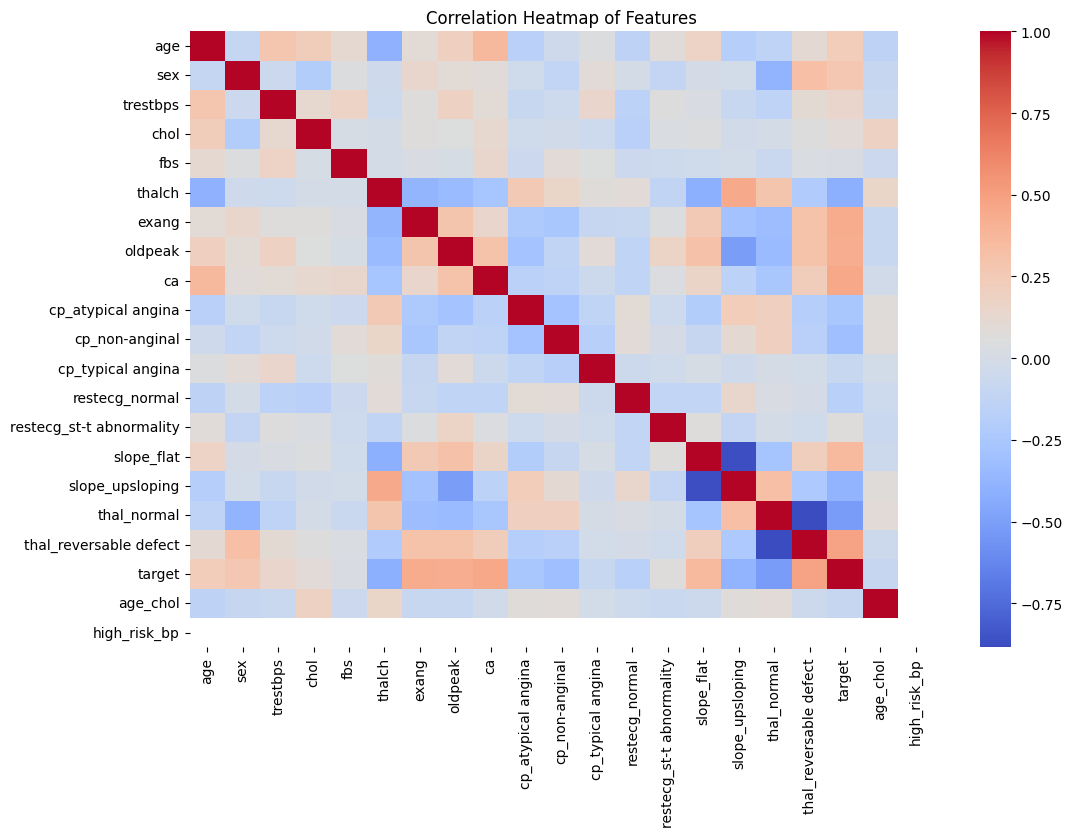

In [69]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_cleveland.corr(), annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features')
plt.savefig('../images/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

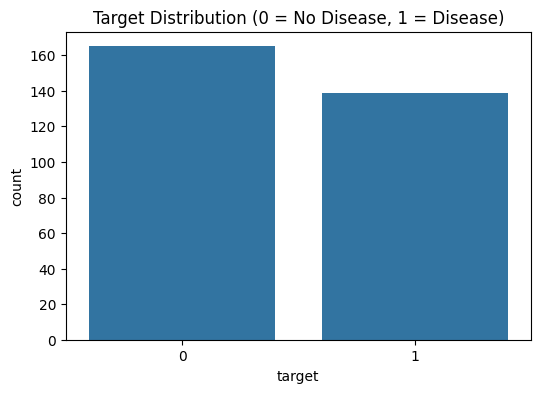

In [70]:
# Target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df_cleveland)
plt.title('Target Distribution (0 = No Disease, 1 = Disease)')
plt.savefig('../images/target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

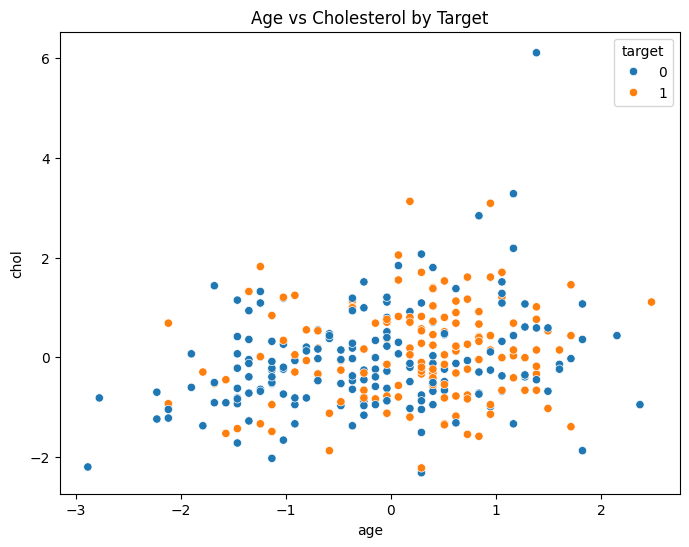

In [71]:
# Age vs Cholesterol scatter
plt.figure(figsize=(8, 6))
sns.scatterplot(x='age', y='chol', hue='target', data=df_cleveland)
plt.title('Age vs Cholesterol by Target')
plt.savefig('../images/age_chol_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

## K-means Clustering
Applying K-means to identify patient groups based on health metrics.

### Determining Optimal Number of Clusters
Using the elbow method to select the best k.

In [72]:
# Select features for clustering (exclude target)
cluster_features = df_cleveland.drop(['target'], axis=1)
print("Clustering Features:", cluster_features.columns.tolist())
print("\nColumns in df_cleveland:", df_cleveland.columns.tolist())

Clustering Features: ['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalch', 'exang', 'oldpeak', 'ca', 'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'restecg_normal', 'restecg_st-t abnormality', 'slope_flat', 'slope_upsloping', 'thal_normal', 'thal_reversable defect', 'age_chol', 'high_risk_bp']

Columns in df_cleveland: ['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalch', 'exang', 'oldpeak', 'ca', 'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'restecg_normal', 'restecg_st-t abnormality', 'slope_flat', 'slope_upsloping', 'thal_normal', 'thal_reversable defect', 'target', 'age_chol', 'high_risk_bp']


### Determining Optimal Number of Clusters
Using the elbow method to select the best k.

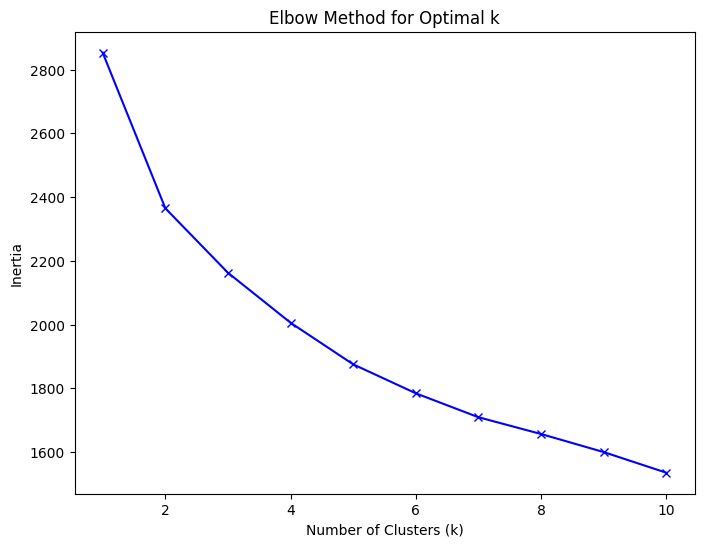

In [73]:
# Calculate inertia for different k values
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(cluster_features)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of Clusters (k)')

plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.savefig('../images/elbow_plot.png', dpi=300, bbox_inches='tight')
plt.show()

### Applying K-means Clustering
Clustering patients with the chosen k.

In [74]:
# Apply K-means with chosen k
k = 3 
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_cleveland['cluster'] = kmeans.fit_predict(cluster_features)
print("Cluster Distribution:\n", df_cleveland['cluster'].value_counts())

Cluster Distribution:
 cluster
1    149
2    111
0     44
Name: count, dtype: int64


### Clustering Visualizations
Visualizing clusters to understand patient groupings.

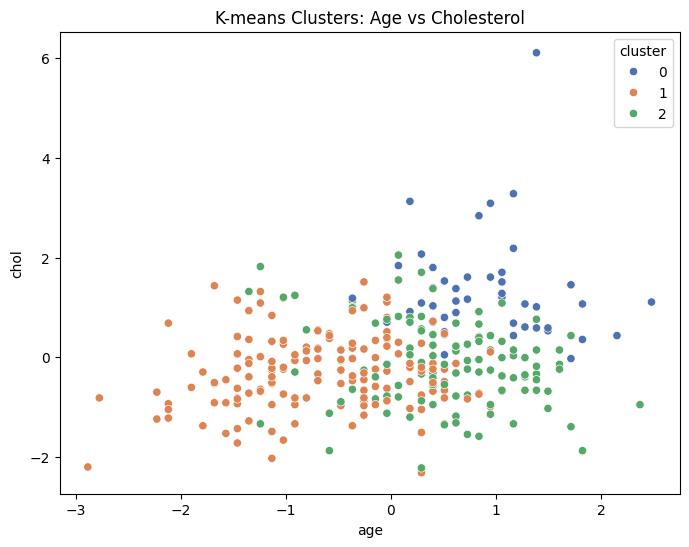

In [75]:
# Scatter plot of clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='age', y='chol', hue='cluster', palette='deep', data=df_cleveland)
plt.title('K-means Clusters: Age vs Cholesterol')
plt.savefig('../images/cluster_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

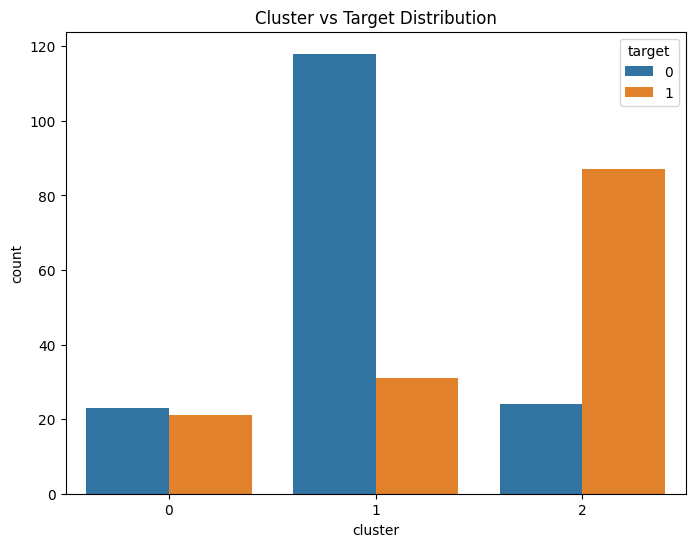

In [76]:
# Cluster vs Target distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='cluster', hue='target', data=df_cleveland)
plt.title('Cluster vs Target Distribution')
plt.savefig('../images/cluster_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### Cluster Analysis
Interpreting the characteristics of each cluster.

In [77]:
# Analyze cluster characteristics
cluster_means = df_cleveland.groupby('cluster')[['age', 'chol', 'thalch', 'oldpeak', 'ca', 'target', 'high_risk_bp']].mean()
print("Cluster Means:\n", cluster_means)

# Save cluster means to CSV
cluster_means.to_csv('../data/cluster_means.csv')

Cluster Means:
               age      chol    thalch   oldpeak        ca    target  \
cluster                                                               
0        0.921793  1.356539  0.106398 -0.215589  0.144056  0.477273   
1       -0.668882 -0.304728  0.600542 -0.458660 -0.464553  0.208054   
2        0.532473 -0.128678 -0.848309  0.701138  0.566486  0.783784   

         high_risk_bp  
cluster                
0                 0.0  
1                 0.0  
2                 0.0  


## Principal Component Analysis (PCA)
Reducing dimensionality to visualize and interpret patient data.

In [78]:
# Select features for PCA (exclude target, cluster)
pca_features = df_cleveland.drop(['target', 'cluster'], axis=1)
print("PCA Features:", pca_features.columns.tolist())
print("\nColumns in df_cleveland:", df_cleveland.columns.tolist())

PCA Features: ['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalch', 'exang', 'oldpeak', 'ca', 'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'restecg_normal', 'restecg_st-t abnormality', 'slope_flat', 'slope_upsloping', 'thal_normal', 'thal_reversable defect', 'age_chol', 'high_risk_bp']

Columns in df_cleveland: ['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalch', 'exang', 'oldpeak', 'ca', 'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina', 'restecg_normal', 'restecg_st-t abnormality', 'slope_flat', 'slope_upsloping', 'thal_normal', 'thal_reversable defect', 'target', 'age_chol', 'high_risk_bp', 'cluster']


### Determining Number of Components
Using explained variance to select principal components.

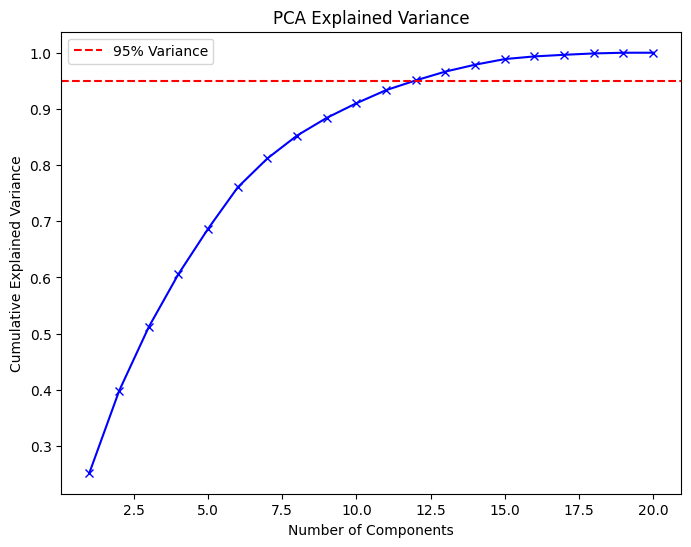

Cumulative Explained Variance: [0.25258987 0.39821139 0.51203193 0.60613199 0.68684782 0.76056436
 0.81194768 0.85267666 0.88413017 0.91013741 0.93343485 0.95073716
 0.96645759 0.97869417 0.98869495 0.99344697 0.99630632 0.99873185
 1.         1.        ]


In [79]:
# Apply PCA
pca = PCA(random_state=42)
pca.fit(pca_features)

# Calculate cumulative explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bx-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.savefig('../images/pca_variance_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("Cumulative Explained Variance:", cumulative_variance)

In [80]:
# Apply PCA with chosen components
n_components = 2  # For visualization
pca = PCA(n_components=n_components, random_state=42)
pca_components = pca.fit_transform(pca_features)
df_pca = pd.DataFrame(pca_components, columns=[f'PC{i+1}' for i in range(n_components)])
df_pca['cluster'] = df_cleveland['cluster']
df_pca['target'] = df_cleveland['target']
print("PCA DataFrame Head:\n", df_pca.head())

PCA DataFrame Head:
         PC1       PC2  cluster  target
0 -0.960791 -0.382863        2       0
1 -3.190621  1.521409        2       1
2 -2.583562 -0.722859        2       1
3  1.115194 -0.458575        1       0
4  1.921559  0.179721        1       0


### PCA Visualizations
Visualizing reduced dimensions to explore patterns.

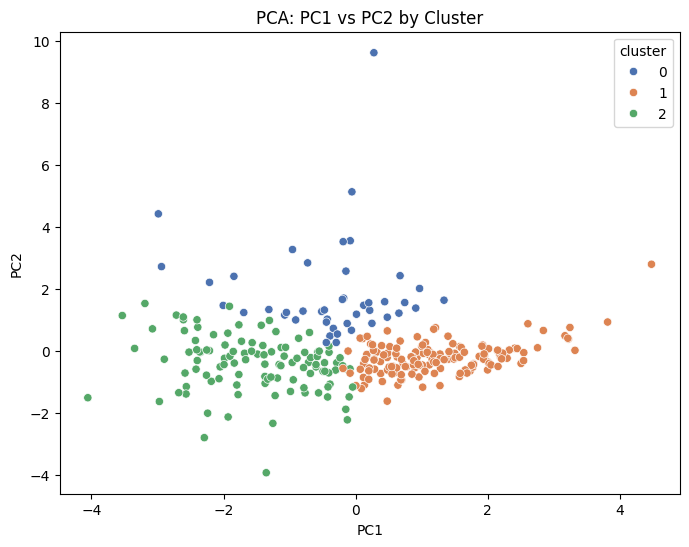

In [81]:
# PCA scatter plot by cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', palette='deep', data=df_pca)
plt.title('PCA: PC1 vs PC2 by Cluster')
plt.savefig('../images/pca_cluster_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

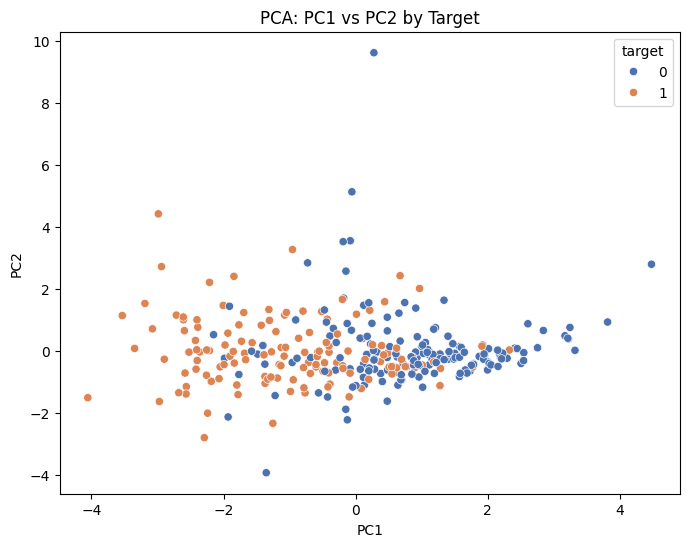

In [82]:
# PCA scatter plot by target
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='target', palette='deep', data=df_pca)
plt.title('PCA: PC1 vs PC2 by Target')
plt.savefig('../images/pca_target_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

### PCA Component Analysis
Interpreting the contribution of original features to principal components.

In [83]:
# Component loadings
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(n_components)], index=pca_features.columns)
print("Component Loadings:\n", loadings)

Component Loadings:
                                PC1       PC2
age                      -0.450359  0.140108
sex                      -0.019204 -0.097186
trestbps                 -0.249683  0.173166
chol                     -0.142448  0.622493
fbs                      -0.029810  0.006158
thalch                    0.457144  0.163835
exang                    -0.119952 -0.033057
oldpeak                  -0.432574 -0.050062
ca                       -0.401087  0.138063
cp_atypical angina        0.082664  0.014938
cp_non-anginal            0.059569  0.021459
cp_typical angina        -0.005248 -0.003543
restecg_normal            0.071191 -0.079271
restecg_st-t abnormality -0.011414 -0.002194
slope_flat               -0.149248 -0.032182
slope_upsloping           0.176702  0.045942
thal_normal               0.150447  0.039543
thal_reversable defect   -0.125658 -0.018554
age_chol                  0.185460  0.701328
high_risk_bp             -0.000000  0.000000


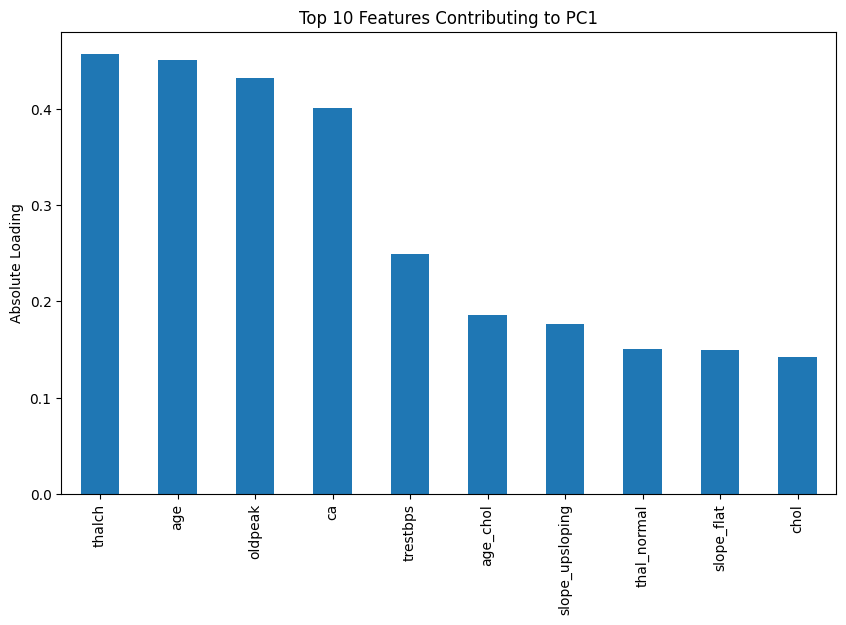

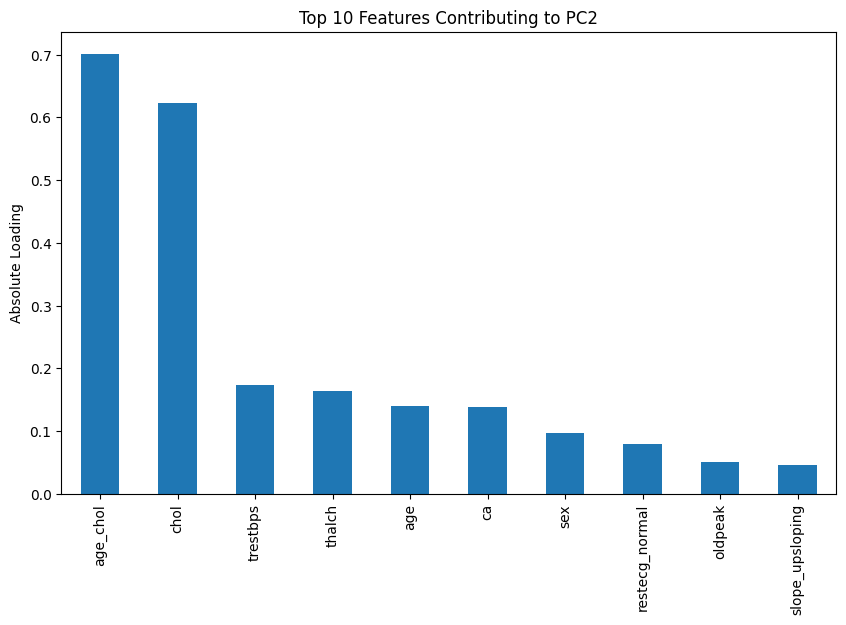

In [84]:
# Visualize top contributing features for PC1 and PC2
plt.figure(figsize=(10, 6))
loadings['PC1'].abs().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 Features Contributing to PC1')
plt.ylabel('Absolute Loading')
plt.savefig('../images/pc1_loadings.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
loadings['PC2'].abs().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 Features Contributing to PC2')
plt.ylabel('Absolute Loading')
plt.savefig('../images/pc2_loadings.png', dpi=300, bbox_inches='tight')
plt.show()

## Supervised Learning: Random Forest Classifier
Training a Random Forest model to predict heart disease presence.

In [85]:
# Prepare features and target
X = df_cleveland.drop(['target', 'cluster'], axis=1)
y = df_cleveland['target']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Training Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)
print("Target Distribution in Training Set:\n", y_train.value_counts(normalize=True))

Training Set Shape: (243, 20)
Test Set Shape: (61, 20)
Target Distribution in Training Set:
 target
0    0.54321
1    0.45679
Name: proportion, dtype: float64


### Model Training and Evaluation
Training the Random Forest model and evaluating its performance.

Accuracy: 0.8852459016393442

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.85      0.89        33
           1       0.84      0.93      0.88        28

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



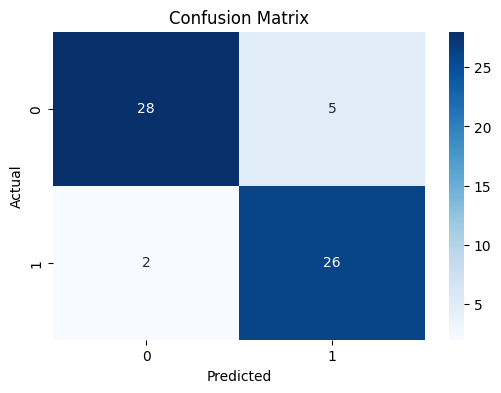

In [86]:
# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('../images/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

### Hyperparameter Tuning
Optimizing the Random Forest model with GridSearchCV.

In [87]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid search
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Evaluate best model
y_pred_best = best_rf.predict(X_test)
print("Tuned Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nTuned Classification Report:\n", classification_report(y_test, y_pred_best))

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-Validation Score: 0.806547619047619
Tuned Accuracy: 0.8688524590163934

Tuned Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.87        33
           1       0.81      0.93      0.87        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



### Model Insights and Visualizations
Analyzing feature importance and ROC curve.

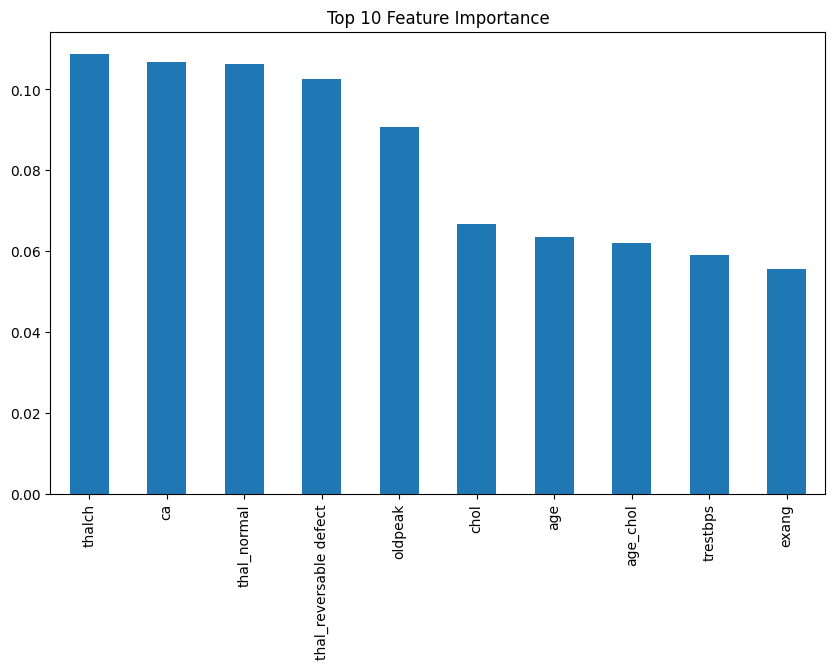

In [88]:
# Feature importance
feature_importance = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importance.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importance')
plt.savefig('../images/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

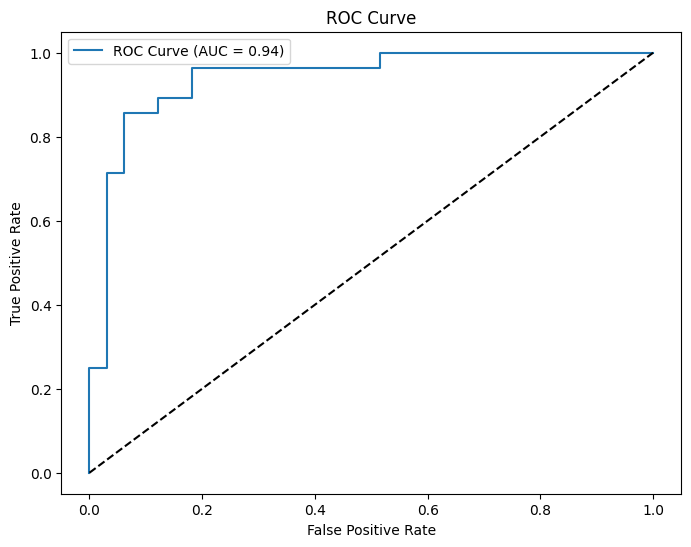

In [89]:
# ROC Curve
y_prob = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('../images/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

### Model Optimization
Improving Random Forest accuracy with feature selection, PCA features, and advanced tuning.

In [90]:
# Feature selection based on importance
top_features = feature_importance.head(10).index.tolist()
print("Top 10 Features:", top_features)

# Prepare reduced feature set
X_selected = X[top_features]
X_train_selected, X_test_selected, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Retrain Random Forest with selected features
rf_selected = RandomForestClassifier(random_state=42)
rf_selected.fit(X_train_selected, y_train)
y_pred_selected = rf_selected.predict(X_test_selected)
print("Accuracy with Selected Features:", accuracy_score(y_test, y_pred_selected))
print("\nClassification Report with Selected Features:\n", classification_report(y_test, y_pred_selected))

Top 10 Features: ['thalch', 'ca', 'thal_normal', 'thal_reversable defect', 'oldpeak', 'chol', 'age', 'age_chol', 'trestbps', 'exang']
Accuracy with Selected Features: 0.8524590163934426

Classification Report with Selected Features:
               precision    recall  f1-score   support

           0       0.90      0.82      0.86        33
           1       0.81      0.89      0.85        28

    accuracy                           0.85        61
   macro avg       0.85      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61



In [91]:
# Apply PCA with components capturing 95% variance
pca_features = df_cleveland.drop(['target', 'cluster'], axis=1)
pca = PCA(n_components=12, random_state=42)  # Adjust n_components based on 95% variance
X_pca = pca.fit_transform(pca_features)

# Train/test split with PCA features
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# Retrain Random Forest with PCA features
rf_pca = RandomForestClassifier(random_state=42)
rf_pca.fit(X_train_pca, y_train)
y_pred_pca = rf_pca.predict(X_test_pca)
print("Accuracy with PCA Features:", accuracy_score(y_test, y_pred_pca))
print("\nClassification Report with PCA Features:\n", classification_report(y_test, y_pred_pca))

Accuracy with PCA Features: 0.9016393442622951

Classification Report with PCA Features:
               precision    recall  f1-score   support

           0       0.94      0.88      0.91        33
           1       0.87      0.93      0.90        28

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



In [94]:
# Advanced tuning with PCA features
param_grid_advanced = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

grid_search_advanced = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_advanced, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_advanced.fit(X_train_pca, y_train)

# Best model
best_rf_advanced = grid_search_advanced.best_estimator_
print("Best Parameters (Advanced Tuning):", grid_search_advanced.best_params_)
print("Best Cross-Validation Score:", grid_search_advanced.best_score_)

# Evaluate best model
y_pred_advanced = best_rf_advanced.predict(X_test_pca)
print("Final Tuned Accuracy:", accuracy_score(y_test, y_pred_advanced))
print("\nFinal Classification Report:\n", classification_report(y_test, y_pred_advanced))

Best Parameters (Advanced Tuning): {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best Cross-Validation Score: 0.8313775510204081
Final Tuned Accuracy: 0.9180327868852459

Final Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.88      0.92        33
           1       0.87      0.96      0.92        28

    accuracy                           0.92        61
   macro avg       0.92      0.92      0.92        61
weighted avg       0.92      0.92      0.92        61



### Updated Model Visualizations
Visualizing the optimized model's performance.

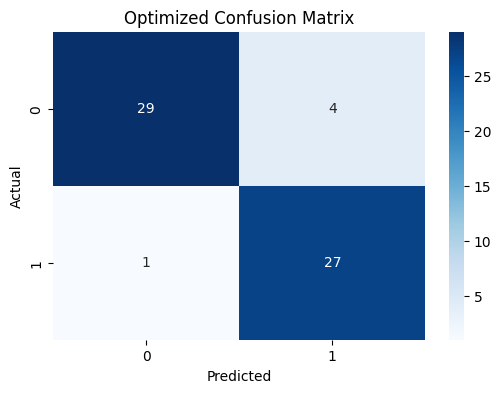

In [95]:
# Updated Confusion Matrix
cm_advanced = confusion_matrix(y_test, y_pred_advanced)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_advanced, annot=True, fmt='d', cmap='Blues')
plt.title('Optimized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('../images/optimized_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

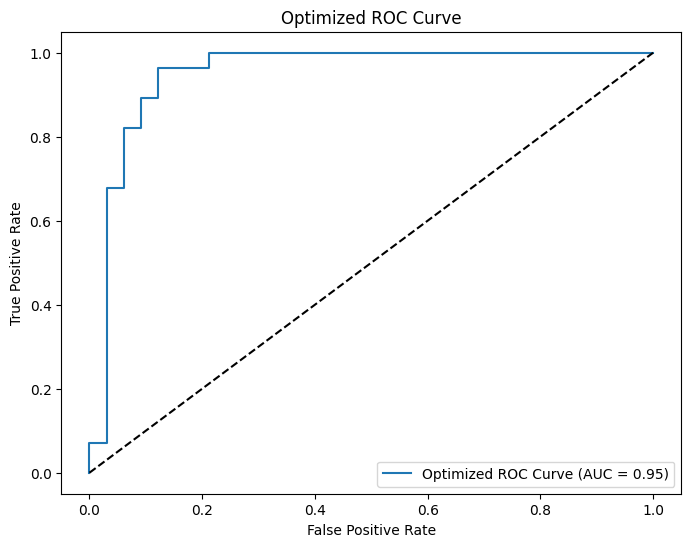

In [96]:
# Updated ROC Curve
y_prob_advanced = best_rf_advanced.predict_proba(X_test_pca)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob_advanced)
roc_auc_advanced = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Optimized ROC Curve (AUC = {roc_auc_advanced:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Optimized ROC Curve')
plt.legend()
plt.savefig('../images/optimized_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

### Check Class Imbalance
Assessing target distribution to improve model performance.

In [102]:
# Check target distribution
print("Target Distribution in Full Dataset:\n", y.value_counts(normalize=True))
print("Target Distribution in Training Set:\n", y_train.value_counts(normalize=True))

Target Distribution in Full Dataset:
 target
0    0.542763
1    0.457237
Name: proportion, dtype: float64
Target Distribution in Training Set:
 target
0    0.54321
1    0.45679
Name: proportion, dtype: float64


In [103]:
# Retrain Random Forest with class weights
rf_weighted = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_weighted.fit(X_train_pca, y_train)
y_pred_weighted = rf_weighted.predict(X_test_pca)
print("Accuracy with Class Weights:", accuracy_score(y_test, y_pred_weighted))
print("\nClassification Report with Class Weights:\n", classification_report(y_test, y_pred_weighted))

Accuracy with Class Weights: 0.8688524590163934

Classification Report with Class Weights:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89        33
           1       0.92      0.79      0.85        28

    accuracy                           0.87        61
   macro avg       0.88      0.86      0.87        61
weighted avg       0.87      0.87      0.87        61



### Additional Feature Engineering
Creating new features to capture more patterns.

In [104]:
# Add new interaction term: thalch * oldpeak
df_cleveland['thalch_oldpeak'] = df_cleveland['thalch'] * df_cleveland['oldpeak']

# Update PCA features with new term
pca_features = df_cleveland.drop(['target', 'cluster'], axis=1)
pca = PCA(n_components=12, random_state=42)  # Adjust n_components for 95% variance
X_pca = pca.fit_transform(pca_features)
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# Retrain Random Forest with updated features
rf_new_features = RandomForestClassifier(random_state=42)
rf_new_features.fit(X_train_pca, y_train)
y_pred_new_features = rf_new_features.predict(X_test_pca)
print("Accuracy with New Features:", accuracy_score(y_test, y_pred_new_features))
print("\nClassification Report with New Features:\n", classification_report(y_test, y_pred_new_features))

Accuracy with New Features: 0.9508196721311475

Classification Report with New Features:
               precision    recall  f1-score   support

           0       0.97      0.94      0.95        33
           1       0.93      0.96      0.95        28

    accuracy                           0.95        61
   macro avg       0.95      0.95      0.95        61
weighted avg       0.95      0.95      0.95        61



In [105]:
# Advanced tuning with updated PCA features
grid_search_advanced = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_advanced, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_advanced.fit(X_train_pca, y_train)

# Best model
best_rf_advanced = grid_search_advanced.best_estimator_
print("Best Parameters (Final Tuning):", grid_search_advanced.best_params_)
print("Best Cross-Validation Score:", grid_search_advanced.best_score_)

# Evaluate best model
y_pred_advanced = best_rf_advanced.predict(X_test_pca)
print("Final Optimized Accuracy:", accuracy_score(y_test, y_pred_advanced))
print("\nFinal Optimized Classification Report:\n", classification_report(y_test, y_pred_advanced))

Best Parameters (Final Tuning): {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Score: 0.8356292517006804
Final Optimized Accuracy: 0.9508196721311475

Final Optimized Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.95        33
           1       0.93      0.96      0.95        28

    accuracy                           0.95        61
   macro avg       0.95      0.95      0.95        61
weighted avg       0.95      0.95      0.95        61



### Final Model Visualizations
Visualizing the fully optimized model's performance.

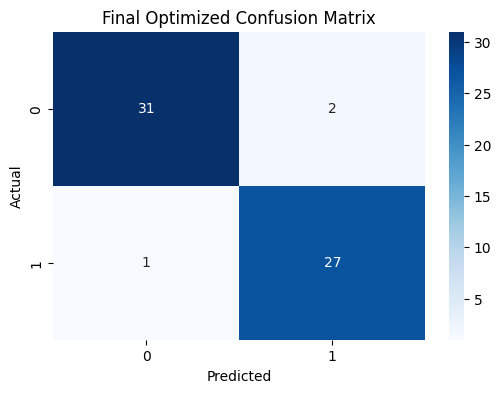

In [106]:
# Final Confusion Matrix
cm_final = confusion_matrix(y_test, y_pred_advanced)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues')
plt.title('Final Optimized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('../images/final_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

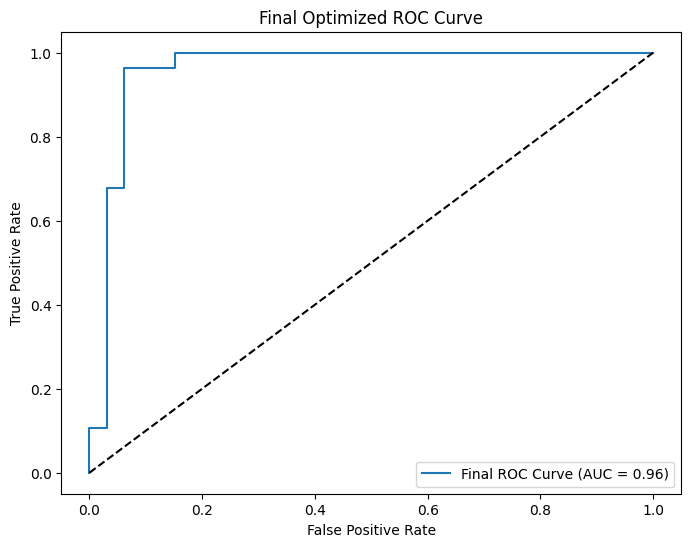

In [107]:
# Final ROC Curve
y_prob_final = best_rf_advanced.predict_proba(X_test_pca)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob_final)
roc_auc_final = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Final ROC Curve (AUC = {roc_auc_final:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final Optimized ROC Curve')
plt.legend()
plt.savefig('../images/final_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()